## Caution: By removing most of the users and items from the dataset, don't be disappointed at the better performance of Popularity over CF

In [1]:
import pandas as pd

df = pd.read_csv('exercise.interactions.csv')
df[['USER_ID', 'ITEM_ID', 'EVENT_TYPE']] = df[['USER_ID', 'ITEM_ID', 'EVENT_TYPE']].astype(str)
print(df.dtypes)
print("num rows", len(df))
df.head()

USER_ID       object
ITEM_ID       object
TIMESTAMP      int64
EVENT_TYPE    object
dtype: object
('num rows', 3637044)


,USER_ID,ITEM_ID,TIMESTAMP,EVENT_TYPE
0,0001c4d4-13af-44c6-b653-a249ce2b2c7e,4644261659414259286,1553269070,submit
1,00042f84-5e34-4dd7-a459-cb8310457f2f,13388854895967500321,1553303518,submit
2,0005f128-5aee-43c1-8c44-eb1fe019179e,7269739074656998882,1553250200,submit
3,000810a5-8eff-47d6-9ead-97add9e07211,18406351456112377421,1553262896,submit
4,000a3365-cab3-41db-b67f-09988b5deff0,9595719689128501283,1553306334,submit


In [2]:
print(df['EVENT_TYPE'].value_counts())
print("unique users", df['USER_ID'].nunique())
print("unique items", df['ITEM_ID'].nunique())

view         2734126
favourite     450098
comment       230305
submit        222515
Name: EVENT_TYPE, dtype: int64
('unique users', 97156)
('unique items', 224858)


In [3]:
user_count = df['USER_ID'].value_counts()
item_count = df['ITEM_ID'].value_counts()

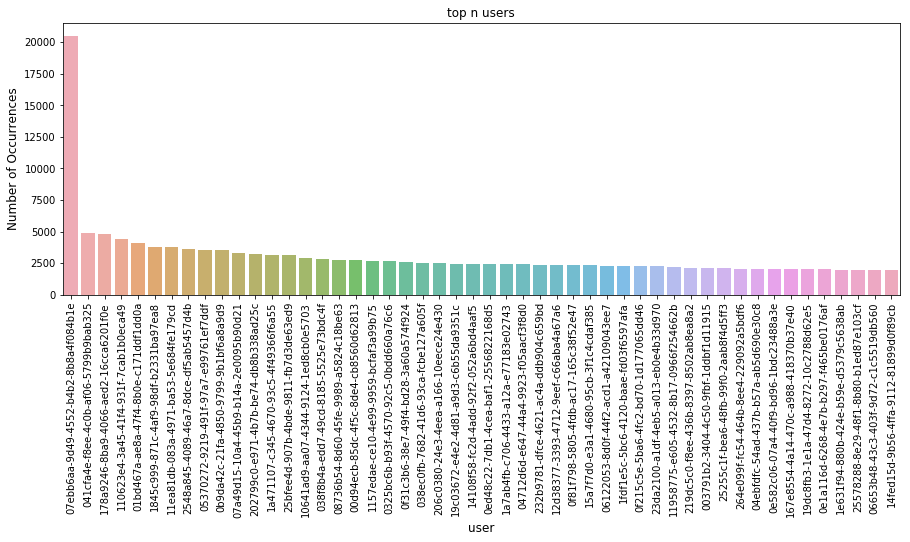

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

top_users = user_count[:50,]
plt.figure(figsize=(15,5))
sns.barplot(top_users.index, top_users.values, alpha=0.8)
plt.title('top n users')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('user', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

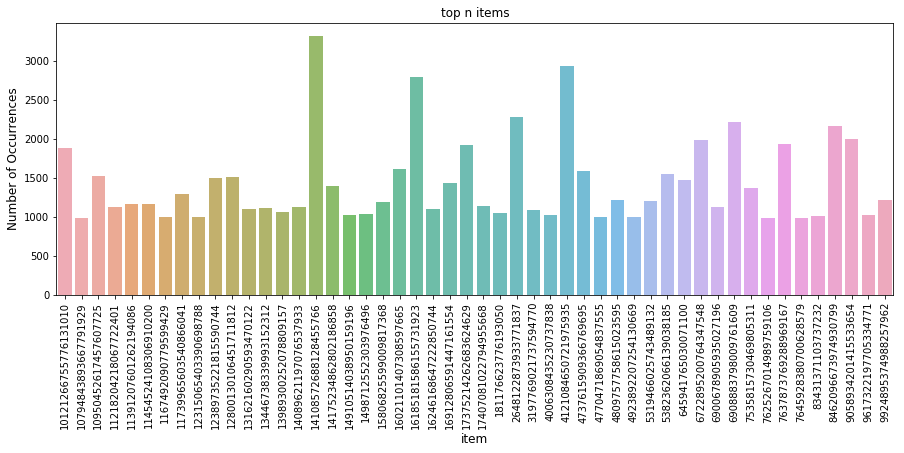

In [5]:
top_items = item_count[:50,]
plt.figure(figsize=(15,5))
sns.barplot(top_items.index, top_items.values, alpha=0.8)
plt.title('top n items')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('item', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [6]:
# Lots of credits to https://www.kaggle.com/gspmoreira
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

event_type_strength = {
   'view': 1.0,
   'favourite': 1.5, 
   'comment': 2.0, 
   'submit': 2.5
}
interactions_df = df
interactions_df['eventStrength'] = interactions_df['EVENT_TYPE'].apply(lambda x: event_type_strength[x])

In [7]:
users_interactions_count_df = interactions_df.groupby(['USER_ID', 'ITEM_ID']).size().groupby('USER_ID').size()
print('# users: %d' % len(users_interactions_count_df))
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 500].reset_index()[['USER_ID']]
print('# users with at least 100 interactions: %d' % len(users_with_enough_interactions_df))

# users: 97156
# users with at least 100 interactions: 114


In [8]:
print('# of interactions: %d' % len(interactions_df))
interactions_from_selected_users_df = interactions_df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'USER_ID',
               right_on = 'USER_ID')
print('# of interactions from users with at least 100 interactions: %d' % len(interactions_from_selected_users_df))

# of interactions: 3637044
# of interactions from users with at least 100 interactions: 185071


In [9]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = interactions_from_selected_users_df \
                    .groupby(['USER_ID', 'ITEM_ID'])['eventStrength'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head(10)

# of unique user/item interactions: 108699


,USER_ID,ITEM_ID,eventStrength
0,00d94ecb-85dc-4f5c-8de4-cb8560d62813,10033332800576582822,1.321928
1,00d94ecb-85dc-4f5c-8de4-cb8560d62813,10061790868135226801,1.321928
2,00d94ecb-85dc-4f5c-8de4-cb8560d62813,10070262853953768226,1.807355
3,00d94ecb-85dc-4f5c-8de4-cb8560d62813,10093759645313790009,1.807355
4,00d94ecb-85dc-4f5c-8de4-cb8560d62813,10129177391098499240,1.321928
5,00d94ecb-85dc-4f5c-8de4-cb8560d62813,1013322354229601115,1.321928
6,00d94ecb-85dc-4f5c-8de4-cb8560d62813,1014680772160727332,1.807355
7,00d94ecb-85dc-4f5c-8de4-cb8560d62813,10178163851062786898,2.459432
8,00d94ecb-85dc-4f5c-8de4-cb8560d62813,10180298016415287344,1.807355
9,00d94ecb-85dc-4f5c-8de4-cb8560d62813,10184461958775257787,1.321928


In [10]:
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['USER_ID'], 
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 86959
# interactions on Test set: 21740


In [11]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = interactions_full_df.set_index('USER_ID')
interactions_train_indexed_df = interactions_train_df.set_index('USER_ID')
interactions_test_indexed_df = interactions_test_df.set_index('USER_ID')

In [12]:
def get_items_interacted(user_id, interactions_df):
    interacted_items = interactions_df.loc[user_id]['ITEM_ID']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [13]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 20

class ModelEvaluator:


    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(interactions_full_df['ITEM_ID'])
        non_interacted_items = all_items - interacted_items

#         random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['ITEM_ID']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['ITEM_ID'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['ITEM_ID'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=get_items_interacted(person_id,
                                                                                    interactions_train_indexed_df),
                                               topn=10000000000)
        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(
                person_id, sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS)

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['ITEM_ID'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['ITEM_ID'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            if idx % 1 == 0 and idx > 0:
               print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()

In [14]:
#Computes the most popular items
item_popularity_df = interactions_full_df.groupby('ITEM_ID')['eventStrength'].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head(10)

,ITEM_ID,eventStrength
0,6722895200764347548,40.210615
1,645941765030071100,39.995250
2,10950452617457607725,39.454411
3,12800130106451711812,39.380540
4,8462096673974930799,37.559016
5,17375214262683624629,36.433008
6,7637873769288969167,35.948438
7,3366657535525719749,33.759404
8,7645928380700628579,33.646210
9,15797858514572693212,31.619227


In [15]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['ITEM_ID'].isin(items_to_ignore)] \
                               .sort_values('eventStrength', ascending = False) \
                               .head(topn)
        return recommendations_df
    
popularity_model = PopularityRecommender(item_popularity_df, None)

print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

Evaluating Popularity recommendation model...
Running evaluation for users
1 users processed
2 users processed
3 users processed
4 users processed
5 users processed
6 users processed
7 users processed
8 users processed
9 users processed
10 users processed
11 users processed
12 users processed
13 users processed
14 users processed
15 users processed
16 users processed
17 users processed
18 users processed
19 users processed
20 users processed
21 users processed
22 users processed
23 users processed
24 users processed
25 users processed
26 users processed
27 users processed
28 users processed
29 users processed
30 users processed
31 users processed
32 users processed
33 users processed
34 users processed
35 users processed
36 users processed
37 users processed
38 users processed
39 users processed
40 users processed
41 users processed
42 users processed
43 users processed
44 users processed
45 users processed
46 users processed
47 users processed
48 users processed
49 users processed
50 

,_person_id,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
0,07ebb6aa-9d49-4552-b4b2-8b8a4f084b1e,920,307,2083,0.441671,0.147384
8,11ea81db-083a-4971-ba53-5e684fe179cd,275,177,642,0.428349,0.275701
12,0ed48c22-7db1-4cea-baf1-2556822168d5,420,365,477,0.880503,0.765199
21,110623e4-3a45-41f4-931f-7cab1b0eca49,289,162,461,0.626898,0.351410
16,178a9246-8ba9-4066-aed2-16cca6201f0e,317,260,407,0.778870,0.638821
40,0b9da42c-21fa-4850-9799-9b1bf6a8a9d9,251,60,372,0.674731,0.161290
37,25578288-8e29-48f1-8b80-b1ed87e103cf,291,226,362,0.803867,0.624309
6,1845c999-871c-4af9-98df-b2331ba97ea8,250,176,334,0.748503,0.526946
80,04712d6d-e647-44a4-9923-f05aacf3f8d0,94,54,333,0.282282,0.162162
17,0a4243c6-c265-4ed2-88c1-405a91675fdb,219,165,319,0.686520,0.517241


## TODO: Content Based filtering using CNN to get feature map of a thumbnail

In [16]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_train_df.pivot(index='USER_ID', columns='ITEM_ID',
                                                          values='eventStrength').fillna(0)

users_items_pivot_matrix_df.head(10)

ITEM_ID,10000589956119446557,10000674119531699073,10001215422468681788,10001252624123777302,1000197292045904400,10002176813989918057,10002387764480903901,10002467083629522091,10002558208116994902,10002596930684643912,...,9996278066395342914,9996414114286294747,9996479166186702526,9996558135294705039,9996649920632306939,9996864033788522024,9997128052594926530,9998547596809293831,9999212324225382792,9999774876316096112
USER_ID,,,,,,,,,,,,,,,,,,,,,
00d94ecb-85dc-4f5c-8de4-cb8560d62813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
00e5e2b2-0ccd-4a52-a021-99518f39bb4c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
00faf4ad-9341-4748-a079-08c5abfa78c5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,1.321928,0.0,0.0,0.0
01764bcc-9dd9-4991-ba16-9460034508c1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
01f4304c-db4e-407c-8428-e938aa47b6c6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.321928,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
0204ad66-6244-457f-a5be-62e55ff13ad9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
0206f666-5e2d-4754-95cf-07a9906e8f1b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
021d6bac-b545-48b3-a2b5-e681ad8f7500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
024b9372-1f71-402c-a243-c99de19a3501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.0


In [17]:
users_items_pivot_matrix = users_items_pivot_matrix_df.as_matrix()
users_items_pivot_matrix[:10]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [18]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

['00d94ecb-85dc-4f5c-8de4-cb8560d62813',
 '00e5e2b2-0ccd-4a52-a021-99518f39bb4c',
 '00faf4ad-9341-4748-a079-08c5abfa78c5',
 '01764bcc-9dd9-4991-ba16-9460034508c1',
 '01f4304c-db4e-407c-8428-e938aa47b6c6',
 '0204ad66-6244-457f-a5be-62e55ff13ad9',
 '0206f666-5e2d-4754-95cf-07a9906e8f1b',
 '021d6bac-b545-48b3-a2b5-e681ad8f7500',
 '024b9372-1f71-402c-a243-c99de19a3501',
 '024c4aa8-311b-4149-bc5f-81cffae0b04f']

In [19]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15
#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)

In [20]:
print(U.shape)
print(Vt.shape)
sigma = np.diag(sigma)
print(sigma.shape)

(114, 15)
(15, 55449)
(15, 15)


In [21]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ -7.64661798e-03,  -1.09314459e-03,   9.16860255e-04, ...,
          5.05430839e-03,  -7.64661798e-03,   8.05623038e-03],
       [  5.12902476e-03,   3.22630283e-05,  -3.25844704e-04, ...,
          2.49312074e-03,   5.12902476e-03,   2.84294733e-03],
       [  1.60974819e-02,  -7.63951156e-06,  -1.86389265e-04, ...,
          7.27964373e-04,   1.60974819e-02,   8.11335954e-04],
       ..., 
       [ -9.42558697e-04,   2.25250526e-04,   1.05397792e-01, ...,
          1.31141835e-02,  -9.42558697e-04,   7.00110307e-02],
       [ -1.92378039e-03,  -6.96360879e-05,   1.91876844e-03, ...,
          3.84047359e-03,  -1.92378039e-03,   5.31973469e-03],
       [ -3.69432315e-03,   8.44178025e-05,  -3.45031887e-04, ...,
          1.69100615e-03,  -3.69432315e-03,   5.18633911e-03]])

In [22]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
len(cf_preds_df.columns)
cf_preds_df.head(10)

,00d94ecb-85dc-4f5c-8de4-cb8560d62813,00e5e2b2-0ccd-4a52-a021-99518f39bb4c,00faf4ad-9341-4748-a079-08c5abfa78c5,01764bcc-9dd9-4991-ba16-9460034508c1,01f4304c-db4e-407c-8428-e938aa47b6c6,0204ad66-6244-457f-a5be-62e55ff13ad9,0206f666-5e2d-4754-95cf-07a9906e8f1b,021d6bac-b545-48b3-a2b5-e681ad8f7500,024b9372-1f71-402c-a243-c99de19a3501,024c4aa8-311b-4149-bc5f-81cffae0b04f,...,2383b529-4193-400d-85e3-3cb8b6ea3104,23ba8d1b-50a9-4a42-ae9f-209d6fb6d00b,2405d549-cb27-4e9b-a499-72417fea4fed,248e0c6a-6016-4938-92a2-3fe687c44c73,2498e937-bc99-483f-832d-982d2dad7d0d,25578288-8e29-48f1-8b80-b1ed87e103cf,2571e9a8-908f-4e29-afcf-7dce1e37c219,25bfee4d-907b-4bde-9811-fb7d3de63ed9,25c3e8c0-9dd7-43b2-ab46-4d186226718e,25c57644-5557-47d6-802c-412968b86a81
ITEM_ID,,,,,,,,,,,,,,,,,,,,,
10000589956119446557,-0.007647,0.005129,0.016097,0.000094,0.003754,6.645305e-03,-0.000502,-0.000918,-0.000092,0.000032,...,-0.001343,-0.000754,-0.000089,0.009495,0.004618,-0.001672,0.012499,-0.000943,-0.001924,-0.003694
10000674119531699073,-0.001093,0.000032,-0.000008,0.000010,-0.000030,-2.565549e-07,0.000050,0.000023,0.000048,0.000436,...,0.000024,-0.000002,-0.000387,-0.000035,0.000012,-0.001038,-0.000039,0.000225,-0.000070,0.000084
10001215422468681788,0.000917,-0.000326,-0.000186,-0.000050,-0.000284,3.145347e-05,0.002438,0.001224,0.007068,-0.000024,...,-0.000042,0.001162,-0.000166,-0.000106,0.009331,-0.000336,0.002210,0.105398,0.001919,-0.000345
10001252624123777302,-0.006648,-0.001617,-0.002151,-0.000080,-0.002093,1.019364e-03,0.034663,0.020653,0.121471,-0.001350,...,0.004707,0.019835,-0.001452,-0.000606,0.151107,0.005855,0.040099,1.712245,0.039023,-0.007255
1000197292045904400,-0.014279,0.015263,0.004173,0.001930,0.006509,1.976880e-03,0.000072,0.001807,-0.000340,-0.000205,...,0.003988,-0.000381,-0.000005,0.000603,0.001555,0.055049,0.002558,-0.011973,0.017090,0.014359
10002176813989918057,-0.001047,0.010004,0.003859,0.003838,0.004108,3.150822e-03,-0.000217,0.000296,0.001565,-0.000476,...,0.000835,0.002614,-0.000079,0.004334,0.002601,-0.003061,0.002199,-0.000910,0.003959,0.001063
10002387764480903901,0.097328,0.029955,0.024383,0.005025,0.044096,1.234682e-02,0.004370,0.003731,0.000047,0.008024,...,0.024288,0.021852,-0.001561,0.016187,0.007220,0.053988,0.086147,-0.010700,0.065502,-0.014892
10002467083629522091,-0.002532,0.005639,0.009217,0.001299,0.002603,4.217799e-02,-0.000456,-0.001457,-0.000322,-0.000102,...,-0.002785,0.000024,-0.000081,0.033466,0.003103,-0.005541,-0.001589,-0.002512,-0.000071,-0.004513
10002558208116994902,0.003276,0.005445,0.001601,0.000728,0.002761,7.835750e-04,0.000105,0.000617,-0.000399,-0.000038,...,0.001143,0.000013,0.000999,0.000610,0.000784,0.022542,0.001706,-0.002593,0.007014,0.003811


In [23]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['ITEM_ID'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)
        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, None)

In [24]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
Running evaluation for users
1 users processed
2 users processed
3 users processed
4 users processed
5 users processed
6 users processed
7 users processed
8 users processed
9 users processed
10 users processed
11 users processed
12 users processed
13 users processed
14 users processed
15 users processed
16 users processed
17 users processed
18 users processed
19 users processed
20 users processed
21 users processed
22 users processed
23 users processed
24 users processed
25 users processed
26 users processed
27 users processed
28 users processed
29 users processed
30 users processed
31 users processed
32 users processed
33 users processed
34 users processed
35 users processed
36 users processed
37 users processed
38 users processed
39 users processed
40 users processed
41 users processed
42 users processed
43 users processed
44 users processed
45 users processed
46 users processed
47 users processed
48 users process

,_person_id,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
0,07ebb6aa-9d49-4552-b4b2-8b8a4f084b1e,238,129,2083,0.114258,0.061930
8,11ea81db-083a-4971-ba53-5e684fe179cd,167,128,642,0.260125,0.199377
12,0ed48c22-7db1-4cea-baf1-2556822168d5,365,298,477,0.765199,0.624738
21,110623e4-3a45-41f4-931f-7cab1b0eca49,144,117,461,0.312364,0.253796
16,178a9246-8ba9-4066-aed2-16cca6201f0e,239,230,407,0.587224,0.565111
40,0b9da42c-21fa-4850-9799-9b1bf6a8a9d9,44,43,372,0.118280,0.115591
37,25578288-8e29-48f1-8b80-b1ed87e103cf,240,220,362,0.662983,0.607735
6,1845c999-871c-4af9-98df-b2331ba97ea8,134,127,334,0.401198,0.380240
80,04712d6d-e647-44a4-9923-f05aacf3f8d0,60,33,333,0.180180,0.099099
17,0a4243c6-c265-4ed2-88c1-405a91675fdb,176,134,319,0.551724,0.420063


In [25]:
global_metrics_df = pd.DataFrame([pop_global_metrics, cf_global_metrics]).set_index('modelName')
global_metrics_df

,recall@10,recall@5
modelName,,
Popularity,0.683211,0.490202
Collaborative Filtering,0.486845,0.419503


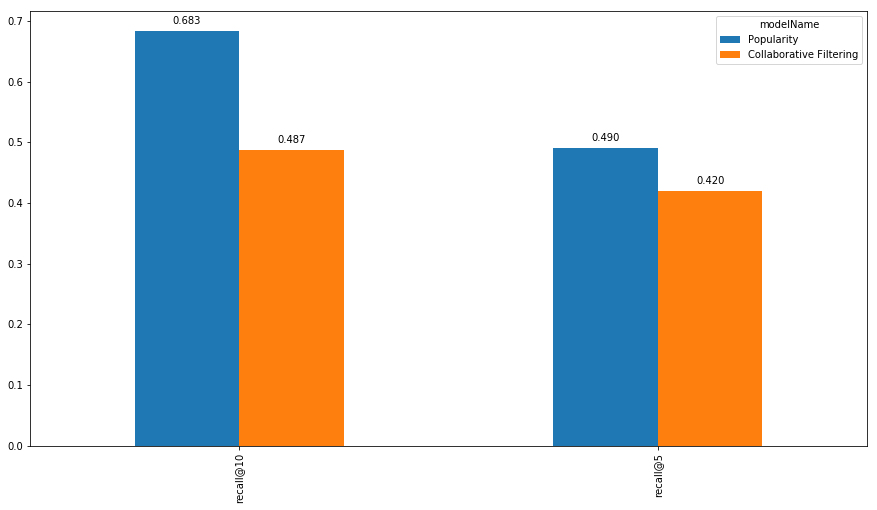

In [26]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')